In [955]:
# import
import jax.numpy as jnp
import pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.fft import fft, ifft, fftfreq
import numpy as np

In [956]:
# Get Data
X_train = pd.read_csv('../data/X_train.csv')
Y_train = pd.read_csv('../data/Y_train.csv')

In [957]:
# Let's see what we have
X_train

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
0,2022-01-01 02:00:00+01:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.000000,NaN
1,2022-01-01 03:00:00+01:00,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.000000,NaN
2,2022-01-01 04:00:00+01:00,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.000000,NaN
3,2022-01-01 05:00:00+01:00,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.000000,NaN
4,2022-01-01 06:00:00+01:00,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...
10600,2023-03-29 19:00:00+02:00,50814.0,3386.0,11952.0,38320.0,7552.0,651.0,247.408490,7.821622,108.11
10601,2023-03-29 20:00:00+02:00,50628.0,3386.0,11952.0,38320.0,8338.0,109.0,155.795012,2.534054,125.66
10602,2023-03-29 21:00:00+02:00,48201.0,3386.0,11952.0,38320.0,9115.0,0.0,126.884684,0.000000,138.01
10603,2023-03-29 22:00:00+02:00,47967.0,3386.0,11952.0,38320.0,9636.0,0.0,156.669189,0.000000,136.74


In [958]:
Y_train

,DELIVERY_START,spot_id_delta
0,2022-01-01 02:00:00+01:00,-36.874770
1,2022-01-01 03:00:00+01:00,-12.643588
2,2022-01-01 04:00:00+01:00,-1.950193
3,2022-01-01 05:00:00+01:00,1.938272
4,2022-01-01 06:00:00+01:00,0.199907
...,...,...
10600,2023-03-29 19:00:00+02:00,6.029303
10601,2023-03-29 20:00:00+02:00,13.576177
10602,2023-03-29 21:00:00+02:00,17.478945
10603,2023-03-29 22:00:00+02:00,17.559407


In [959]:
# Let's see how many values and features do we have
print(f"features: {X_train.shape[1]}")
print(f"size: {X_train.shape[0]}")

features: 10
size: 10605


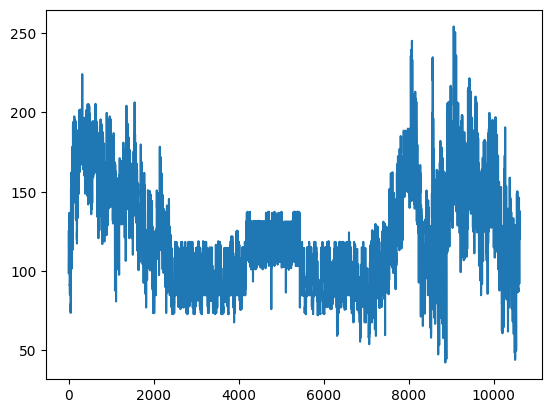

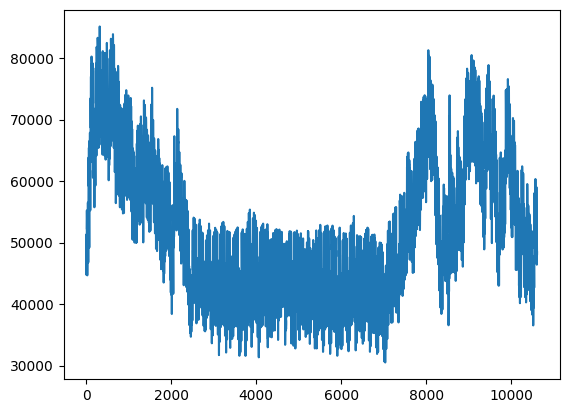

In [960]:
from sklearn.impute import KNNImputer
# Analyse for each column the correlation with the hours and months to replace NA by meaninful values

hours = [(int(X_train["DELIVERY_START"].iloc[i][11:13]) + 1 ) % 24 for i in range(len(X_train["DELIVERY_START"]))]
months = [int(X_train["DELIVERY_START"].iloc[i][5:7]) for i in range(len(X_train["DELIVERY_START"]))]
X_train["hours"] = hours
X_train["months"] = months
X_train = X_train.drop(columns=["DELIVERY_START"])

imputer = KNNImputer(n_neighbors=5)
imputer.fit_transform(X_train)
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

forecast = jnp.array(X_train['load_forecast'])
spot_price = jnp.array(X_train['predicted_spot_price'])

#signal = spot_price[8567:10175]
plt.figure()
plt.plot(spot_price)
plt.show()

plt.figure()
plt.plot(forecast)
plt.show()


load_forecast hours: SpearmanrResult(correlation=0.42869565217391303, pvalue=0.036600023060006086)
load_forecast months: SpearmanrResult(correlation=-0.46153846153846156, pvalue=0.13094806950717278)


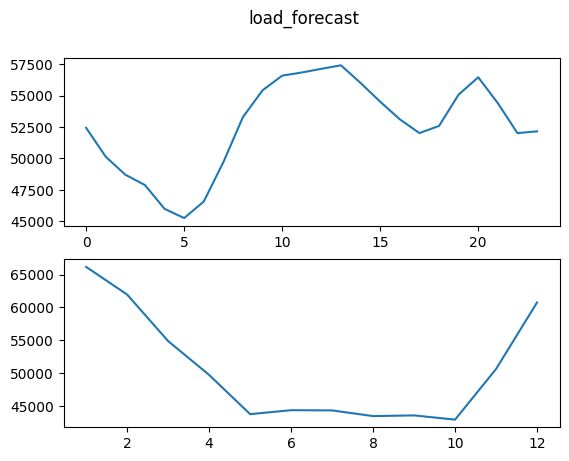

coal_power_available hours: SpearmanrResult(correlation=0.775795176248663, pvalue=8.417203798910672e-06)
coal_power_available months: SpearmanrResult(correlation=-0.3591638357540393, pvalue=0.2515529902663954)


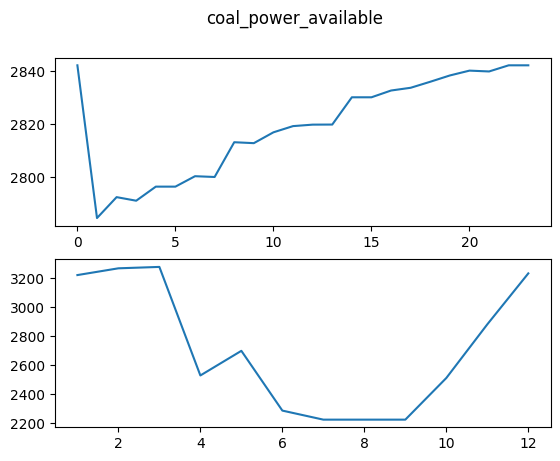

gas_power_available hours: SpearmanrResult(correlation=0.7429317797203859, pvalue=3.204550702020678e-05)
gas_power_available months: SpearmanrResult(correlation=-0.04195804195804196, pvalue=0.8969858708195542)


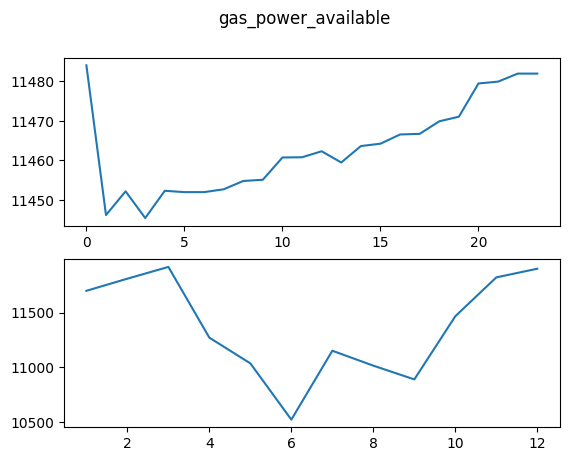

nucelear_power_available hours: SpearmanrResult(correlation=0.8278260869565216, pvalue=5.981436834004455e-07)
nucelear_power_available months: SpearmanrResult(correlation=-0.35664335664335667, pvalue=0.25513775175895725)


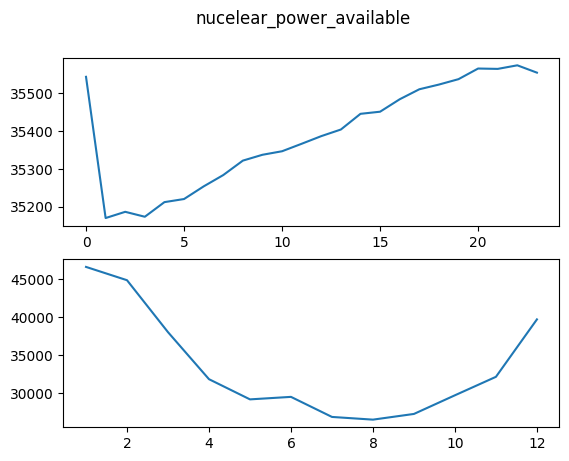

wind_power_forecasts_average hours: SpearmanrResult(correlation=-0.0608695652173913, pvalue=0.7775281884531549)
wind_power_forecasts_average months: SpearmanrResult(correlation=0.027972027972027972, pvalue=0.9312343512018808)


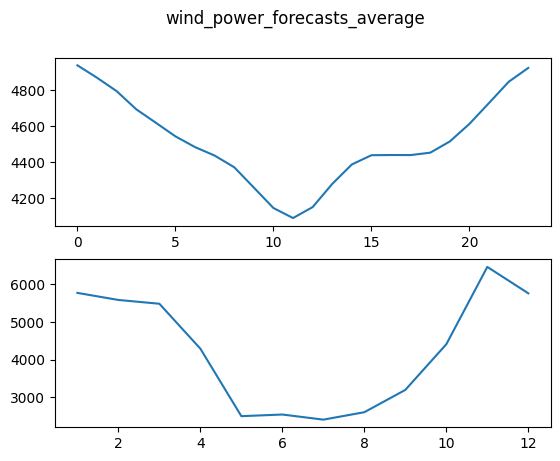

solar_power_forecasts_average hours: SpearmanrResult(correlation=0.43357252601385005, pvalue=0.03429171008921337)
solar_power_forecasts_average months: SpearmanrResult(correlation=-0.06293706293706294, pvalue=0.8459309212287789)


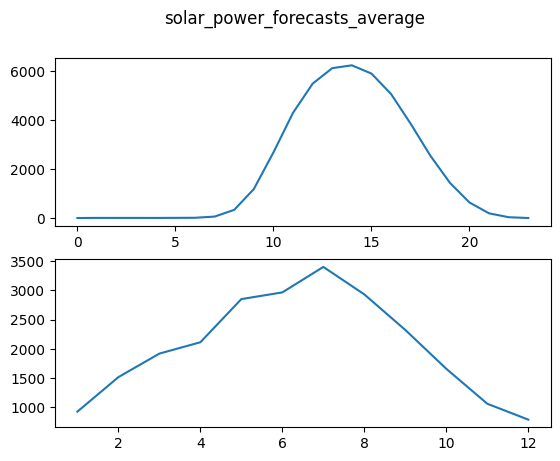

wind_power_forecasts_std hours: SpearmanrResult(correlation=0.7217391304347825, pvalue=6.865036731420534e-05)
wind_power_forecasts_std months: SpearmanrResult(correlation=0.1258741258741259, pvalue=0.6966831093957659)


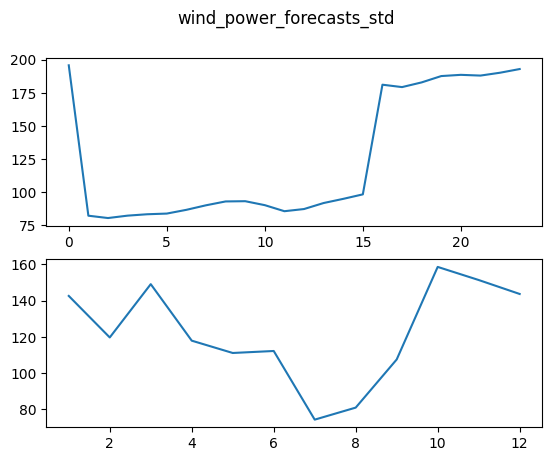

solar_power_forecasts_std hours: SpearmanrResult(correlation=0.5605566559998522, pvalue=0.004382827187812103)
solar_power_forecasts_std months: SpearmanrResult(correlation=-0.09090909090909093, pvalue=0.7787253962454419)


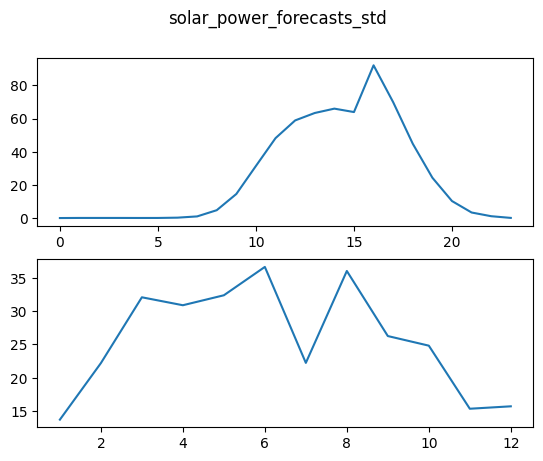

predicted_spot_price hours: SpearmanrResult(correlation=0.5365217391304348, pvalue=0.006874530593332835)
predicted_spot_price months: SpearmanrResult(correlation=-0.39860139860139865, pvalue=0.19933549461780894)


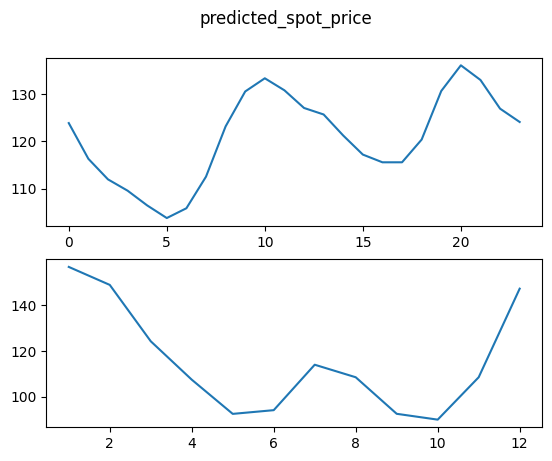

In [961]:
for column in X_train.columns:
    if column not in ["hours",  "months"]:
        c = X_train[[column, "hours", "months"]]
        c = c.dropna()
        c_hours = c[[column, "hours"]].groupby("hours").mean()
        c_months = c[[column, "months"]].groupby("months").mean()
        print(f"{column} hours: {spearmanr(c_hours[column], c_hours.index)}")
        print(f"{column} months: {spearmanr(c_months[column], c_months.index)}")
        fig, axs = plt.subplots(2)
        fig.suptitle(column)
        axs[0].plot(c_hours)
        axs[1].plot(c_months)
        plt.show()

In [962]:
for column in X_train.columns:
    if column not in ["hours",  "months", "DELIVERY_START"]:
        c = X_train[[column, "hours", "months"]]
        c = c[c[column].isna()]
        c[column] = 1
        print(f"{column} has {len(c)} missing values")
        c_hours = c[[column, "hours"]].groupby("hours").count()
        c_months = c[[column, "months"]].groupby("months").count()
        if len(c) > 50:
            fig, axs = plt.subplots(2)
            fig.suptitle(column)
            axs[0].plot(c_hours)
            axs[1].plot(c_months)
            plt.show()

load_forecast has 0 missing values
coal_power_available has 0 missing values
gas_power_available has 0 missing values
nucelear_power_available has 0 missing values
wind_power_forecasts_average has 0 missing values
solar_power_forecasts_average has 0 missing values
wind_power_forecasts_std has 0 missing values
solar_power_forecasts_std has 0 missing values
predicted_spot_price has 0 missing values


load_forecast time: SpearmanrResult(correlation=-0.327609523005759, pvalue=1.2451301398756111e-08)


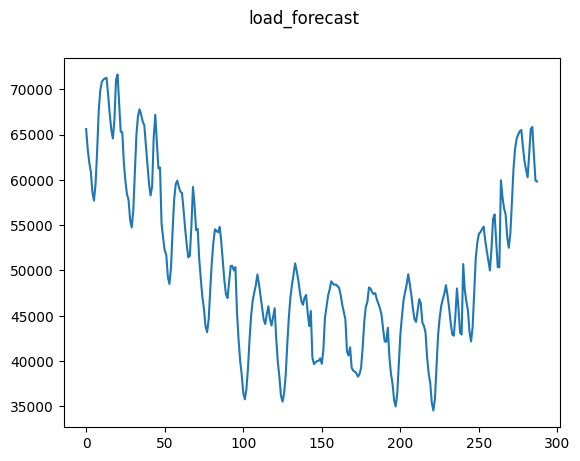

coal_power_available time: SpearmanrResult(correlation=-0.34920446677913747, pvalue=1.1059520718301681e-09)


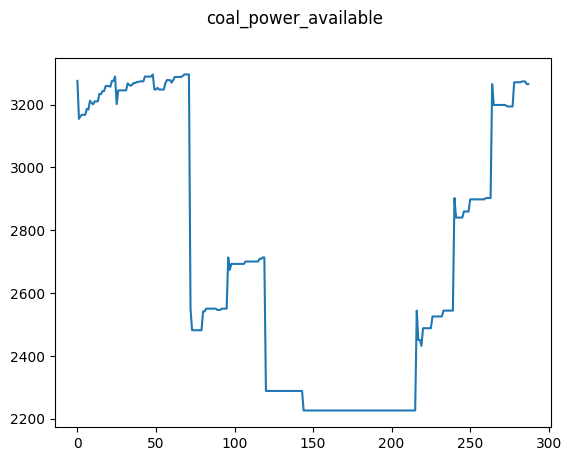

gas_power_available time: SpearmanrResult(correlation=-0.037883813218285545, pvalue=0.5219492751280252)


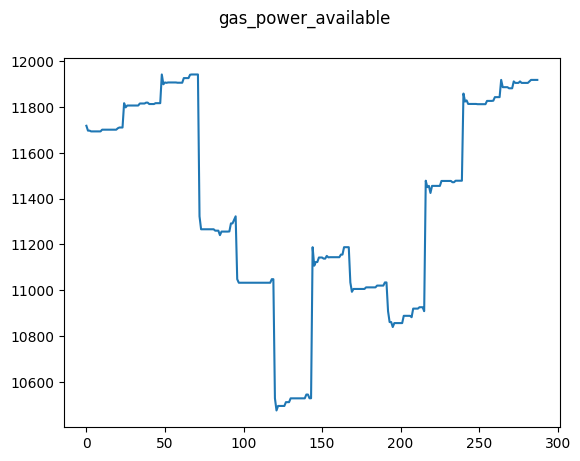

nucelear_power_available time: SpearmanrResult(correlation=-0.35304845925074596, pvalue=7.046891193864199e-10)


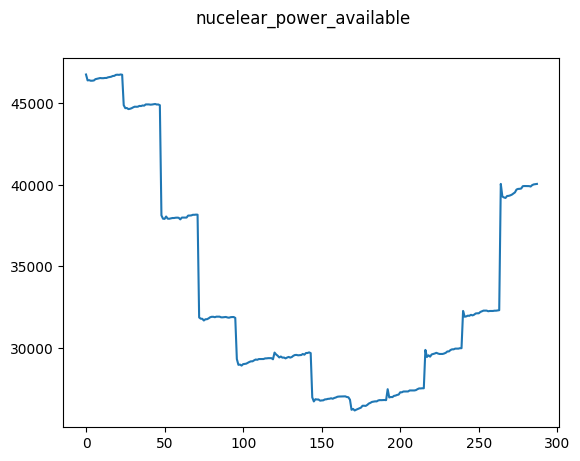

wind_power_forecasts_average time: SpearmanrResult(correlation=-0.004299639511471735, pvalue=0.9420843948014044)


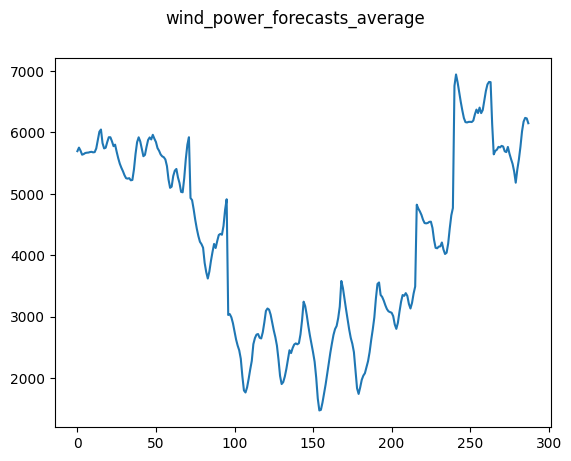

solar_power_forecasts_average time: SpearmanrResult(correlation=-0.0474833364653067, pvalue=0.422109200461548)


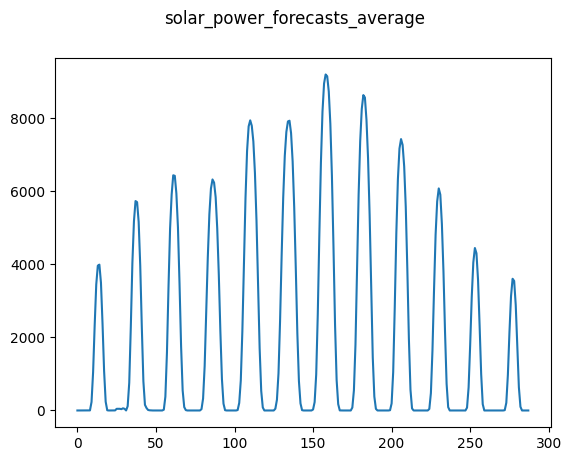

wind_power_forecasts_std time: SpearmanrResult(correlation=0.09947895944604528, pvalue=0.09197813584450139)


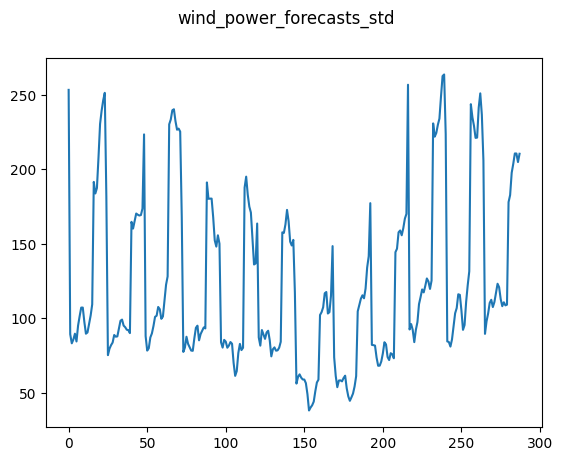

solar_power_forecasts_std time: SpearmanrResult(correlation=-0.0528859384151194, pvalue=0.37120051406548393)


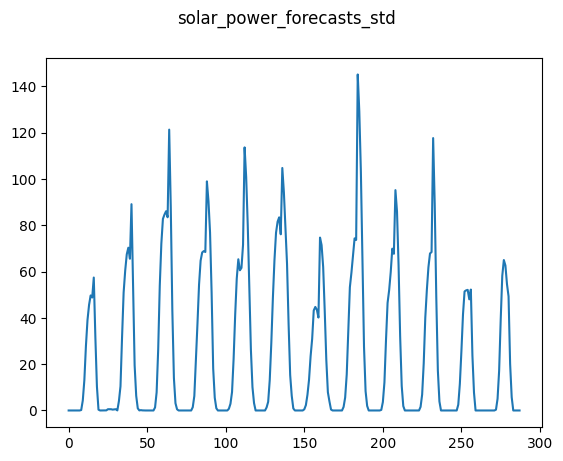

predicted_spot_price time: SpearmanrResult(correlation=-0.31233872886011577, pvalue=6.178786700222745e-08)


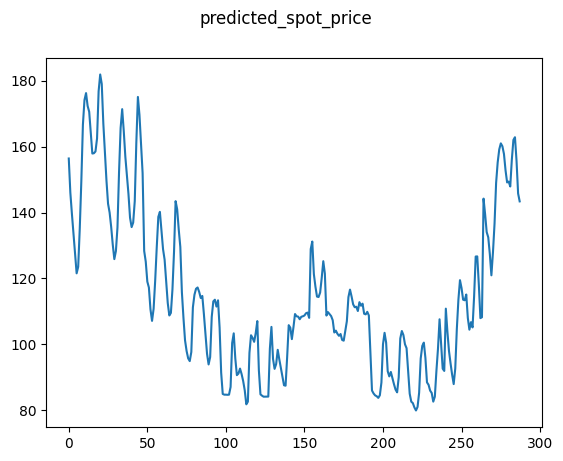

In [963]:
# Let's group by hours and months and see the correlation between the hours/months mean and hours/months index for each column

for column in X_train.columns:
    if column not in ["hours",  "months"]:
        c = X_train[[column, "hours", "months"]]
        c = c.dropna()
        c_time = c.groupby(["months", "hours"]).mean()
        c_time = c_time.reset_index()
        corr = spearmanr(c_time[column], c_time.index)
        print(f"{column} time: {corr}")
        fig, axs = plt.subplots(1)
        fig.suptitle(column)
        axs.plot(c_time[column])
        plt.show()

       load_forecast  coal_power_available  gas_power_available  \
0            49439.0                3386.0              11487.0   
1            46511.0                3386.0              11487.0   
2            45158.0                3386.0              11487.0   
3            44779.0                3386.0              11487.0   
4            45284.0                3386.0              11487.0   
...              ...                   ...                  ...   
10600        50814.0                3386.0              11952.0   
10601        50628.0                3386.0              11952.0   
10602        48201.0                3386.0              11952.0   
10603        47967.0                3386.0              11952.0   
10604        48444.0                3386.0              11952.0   

       nucelear_power_available  wind_power_forecasts_average  \
0                       44118.0                        3035.0   
1                       44118.0                        3143.0   


<AxesSubplot: >

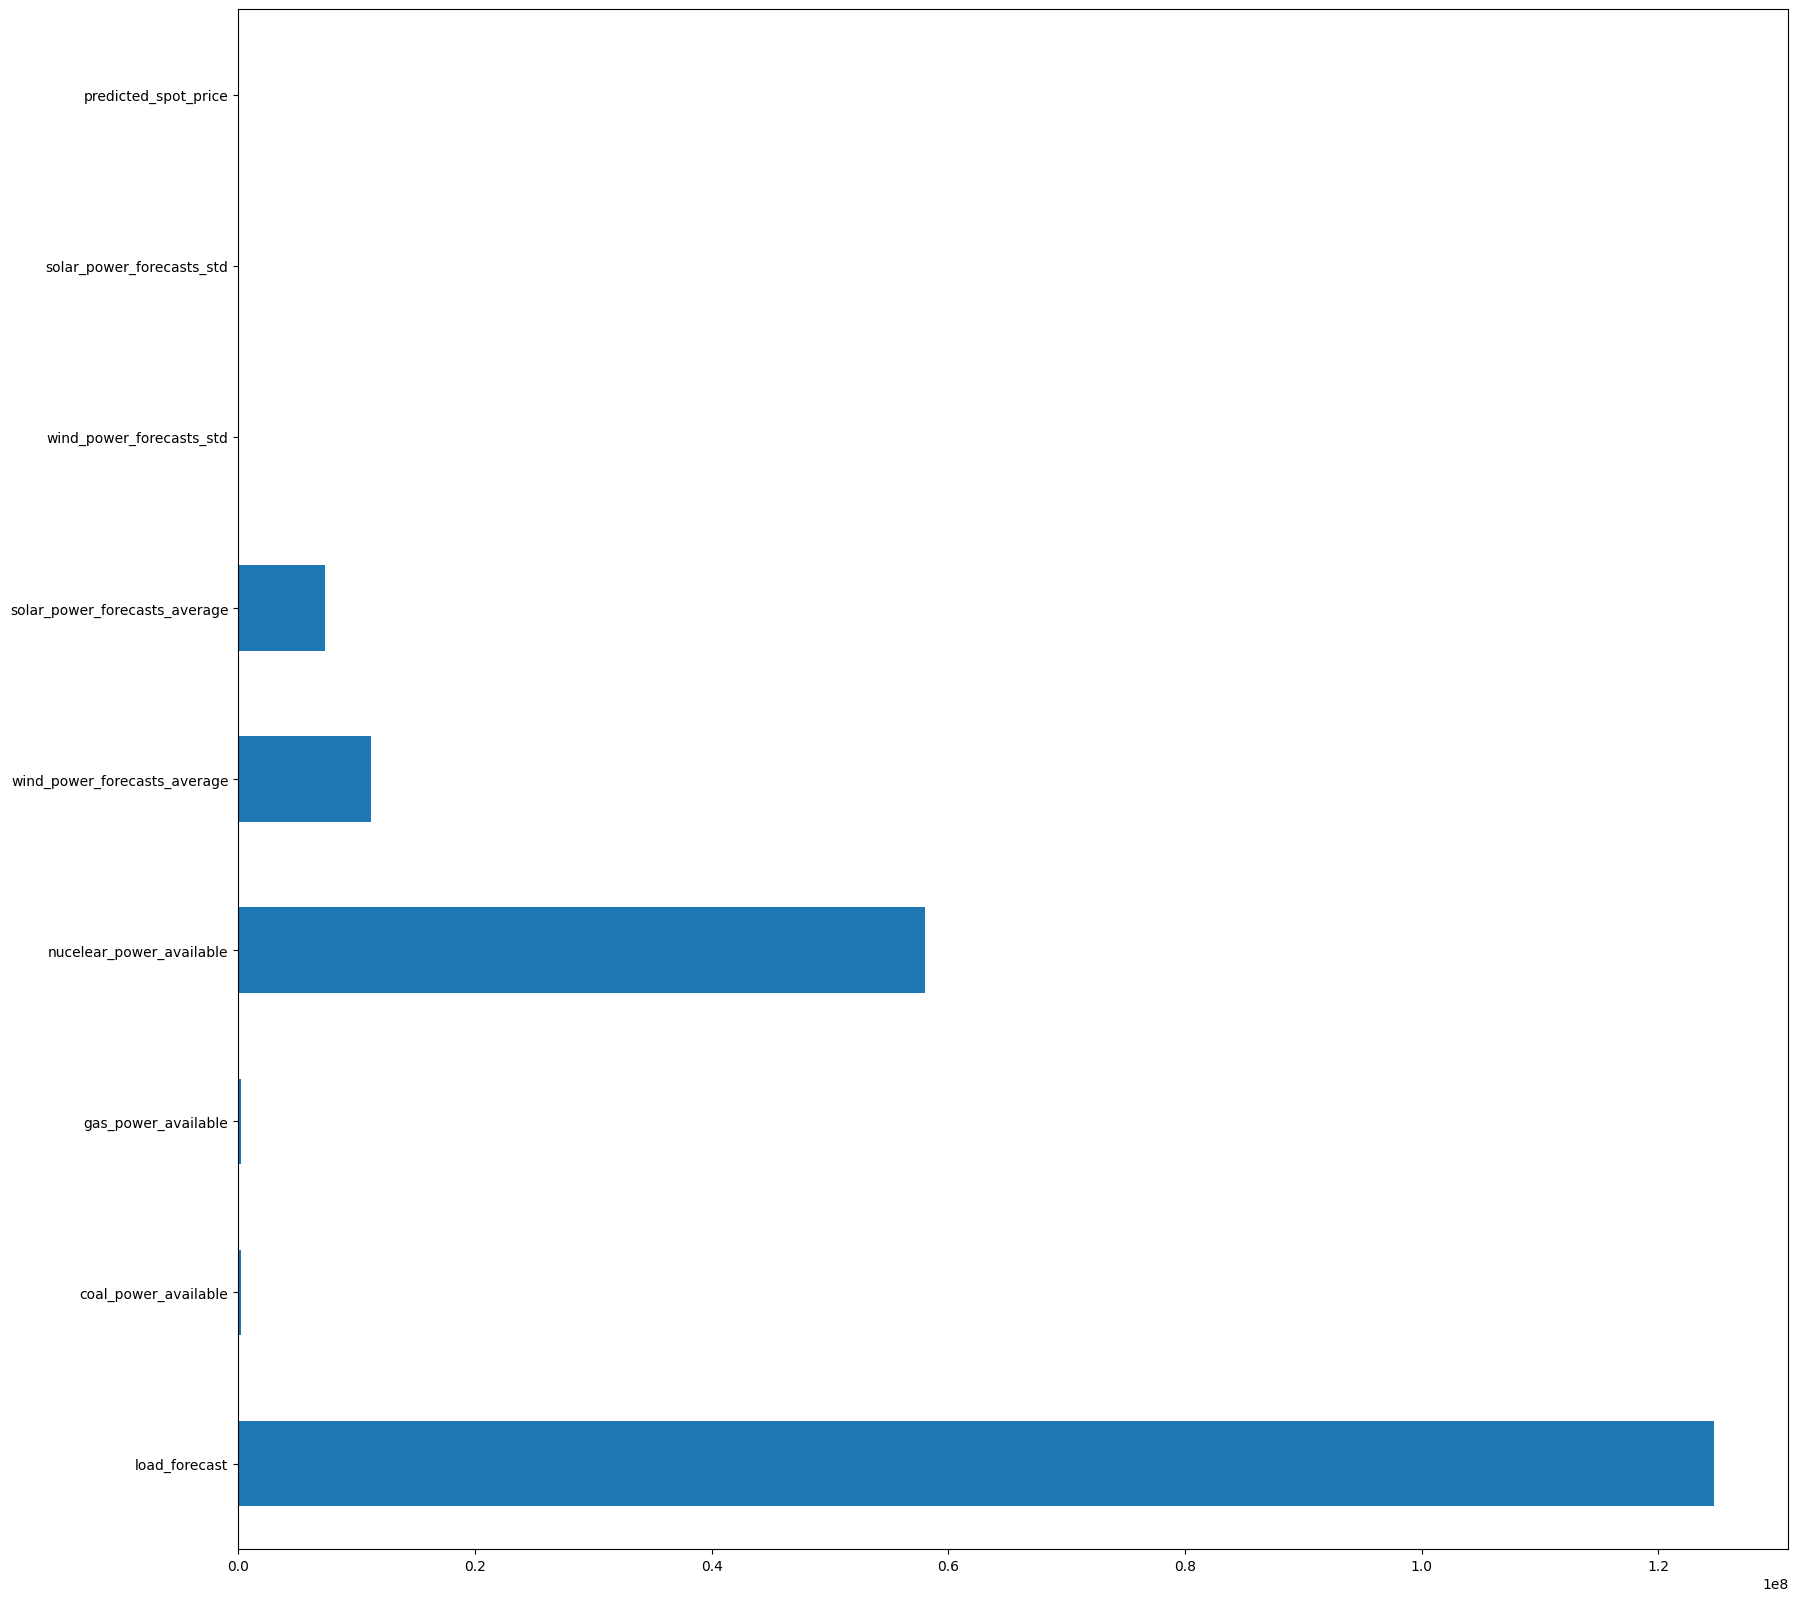

In [964]:
X_train = X_train.drop(columns=["hours", "months"])
print(X_train)
# Get Variance of each feature
var = X_train.var()

plt.figure(figsize=(20, 20))
var.plot(kind='barh')

<AxesSubplot: >

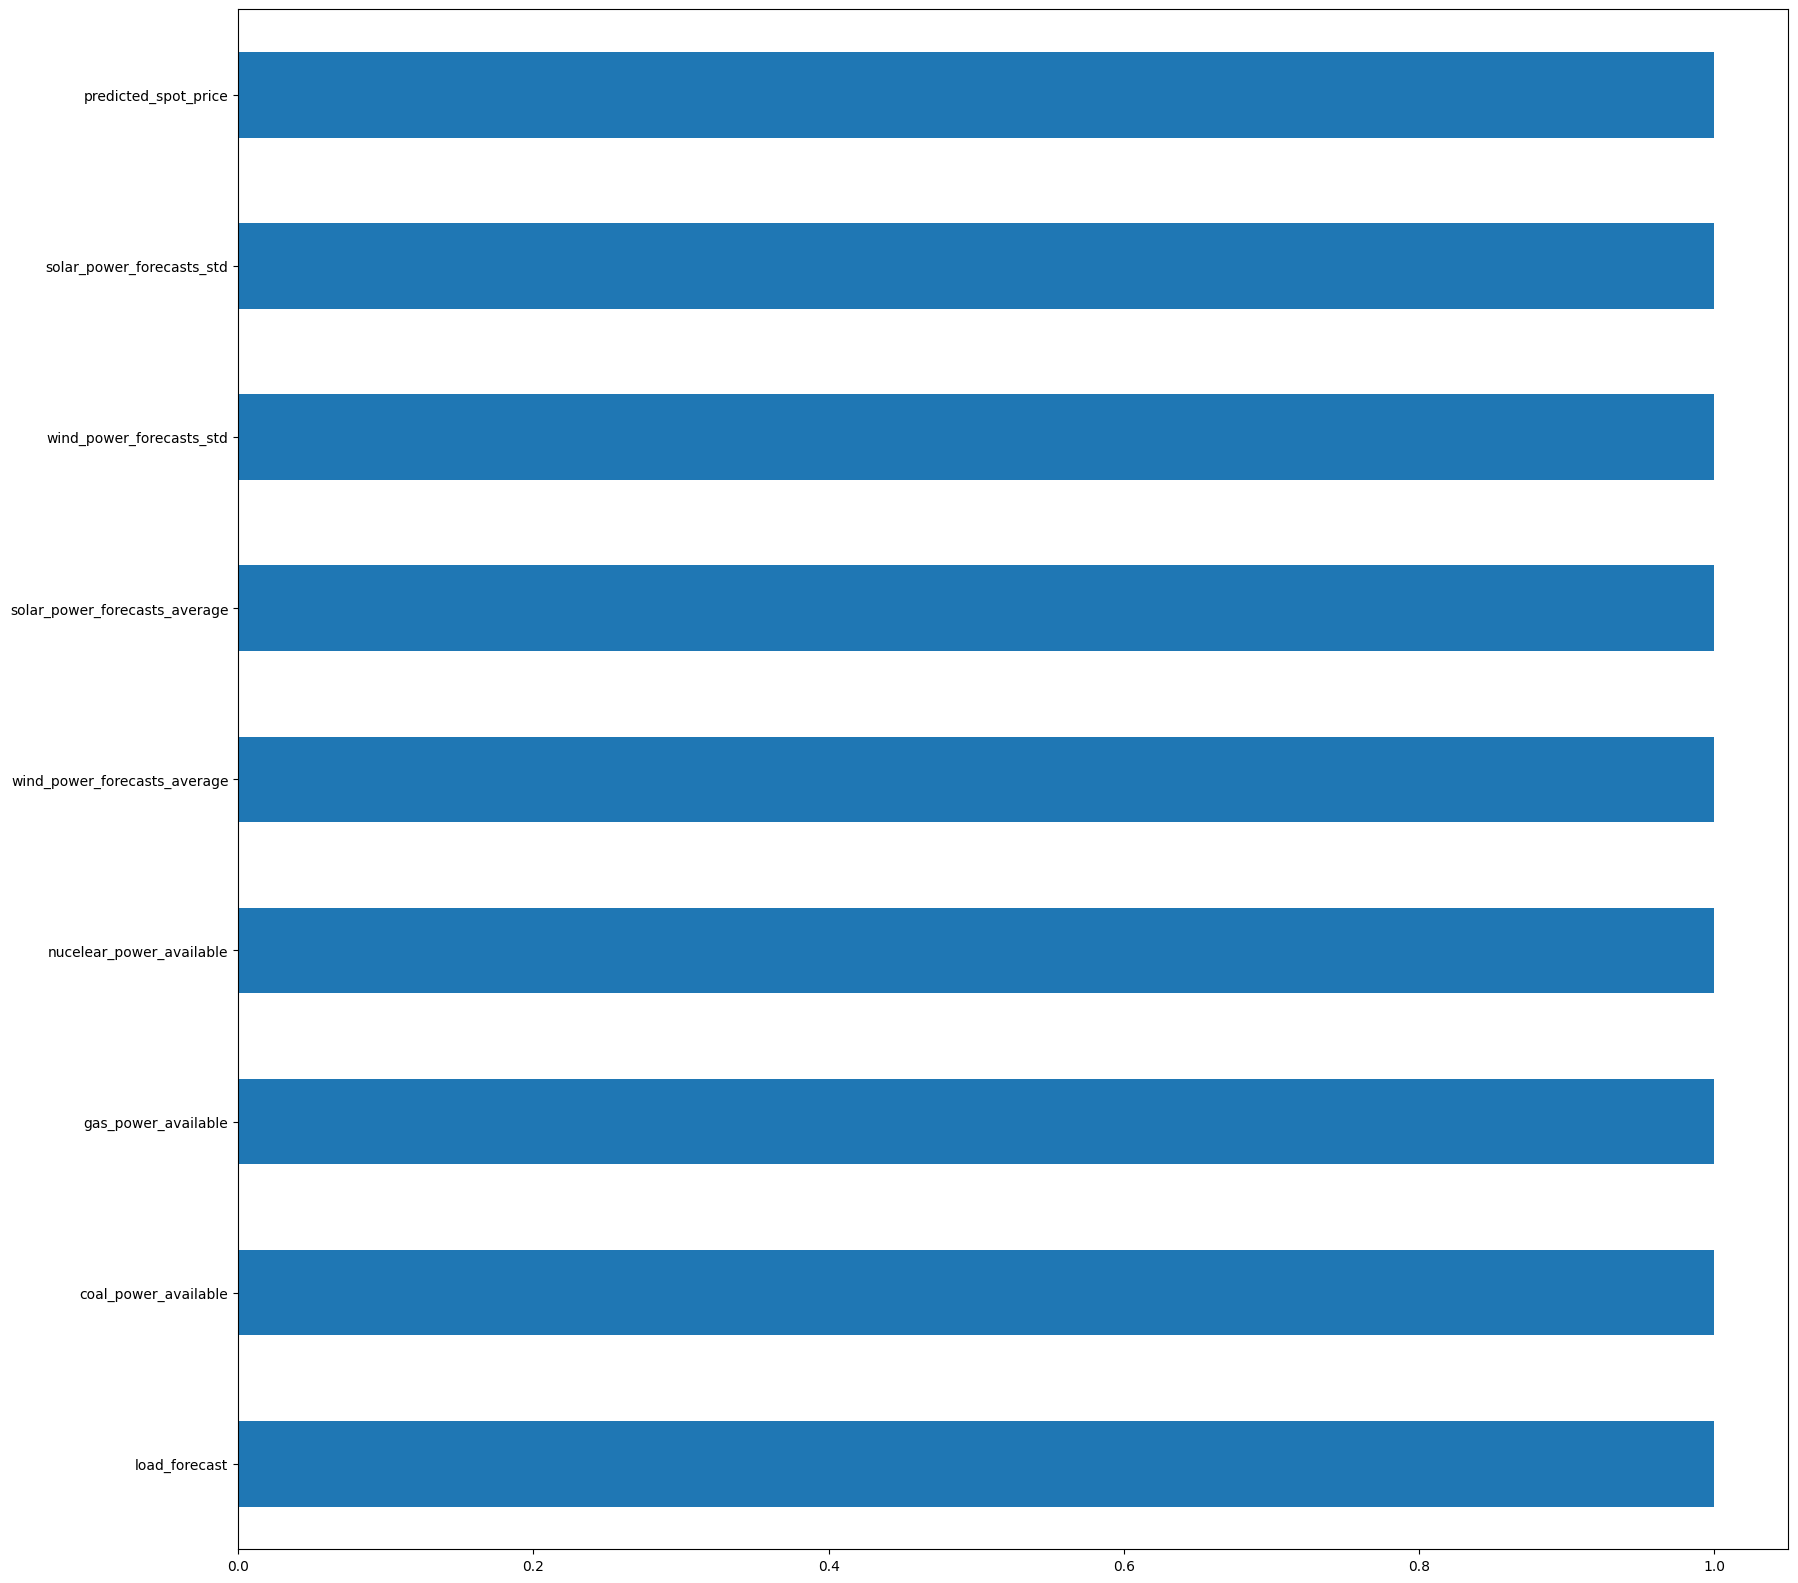

In [965]:
# Normalize the data
X_train = (X_train - X_train.mean()) / X_train.std()
# Get Variance of each feature
var = X_train.var()

plt.figure(figsize=(20, 20))
var.plot(kind='barh')

<AxesSubplot: >

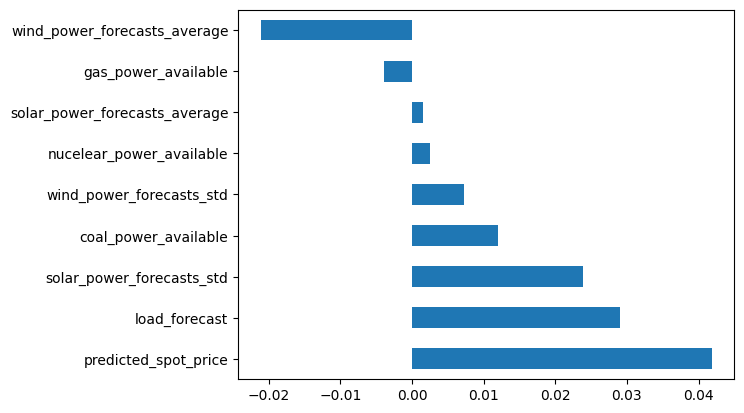

In [966]:
# Let's see the correlation between features and spot_id_delta
correlation = X_train.corrwith(Y_train['spot_id_delta'])
correlation = correlation.sort_values(ascending=False)
correlation.plot(kind='barh')

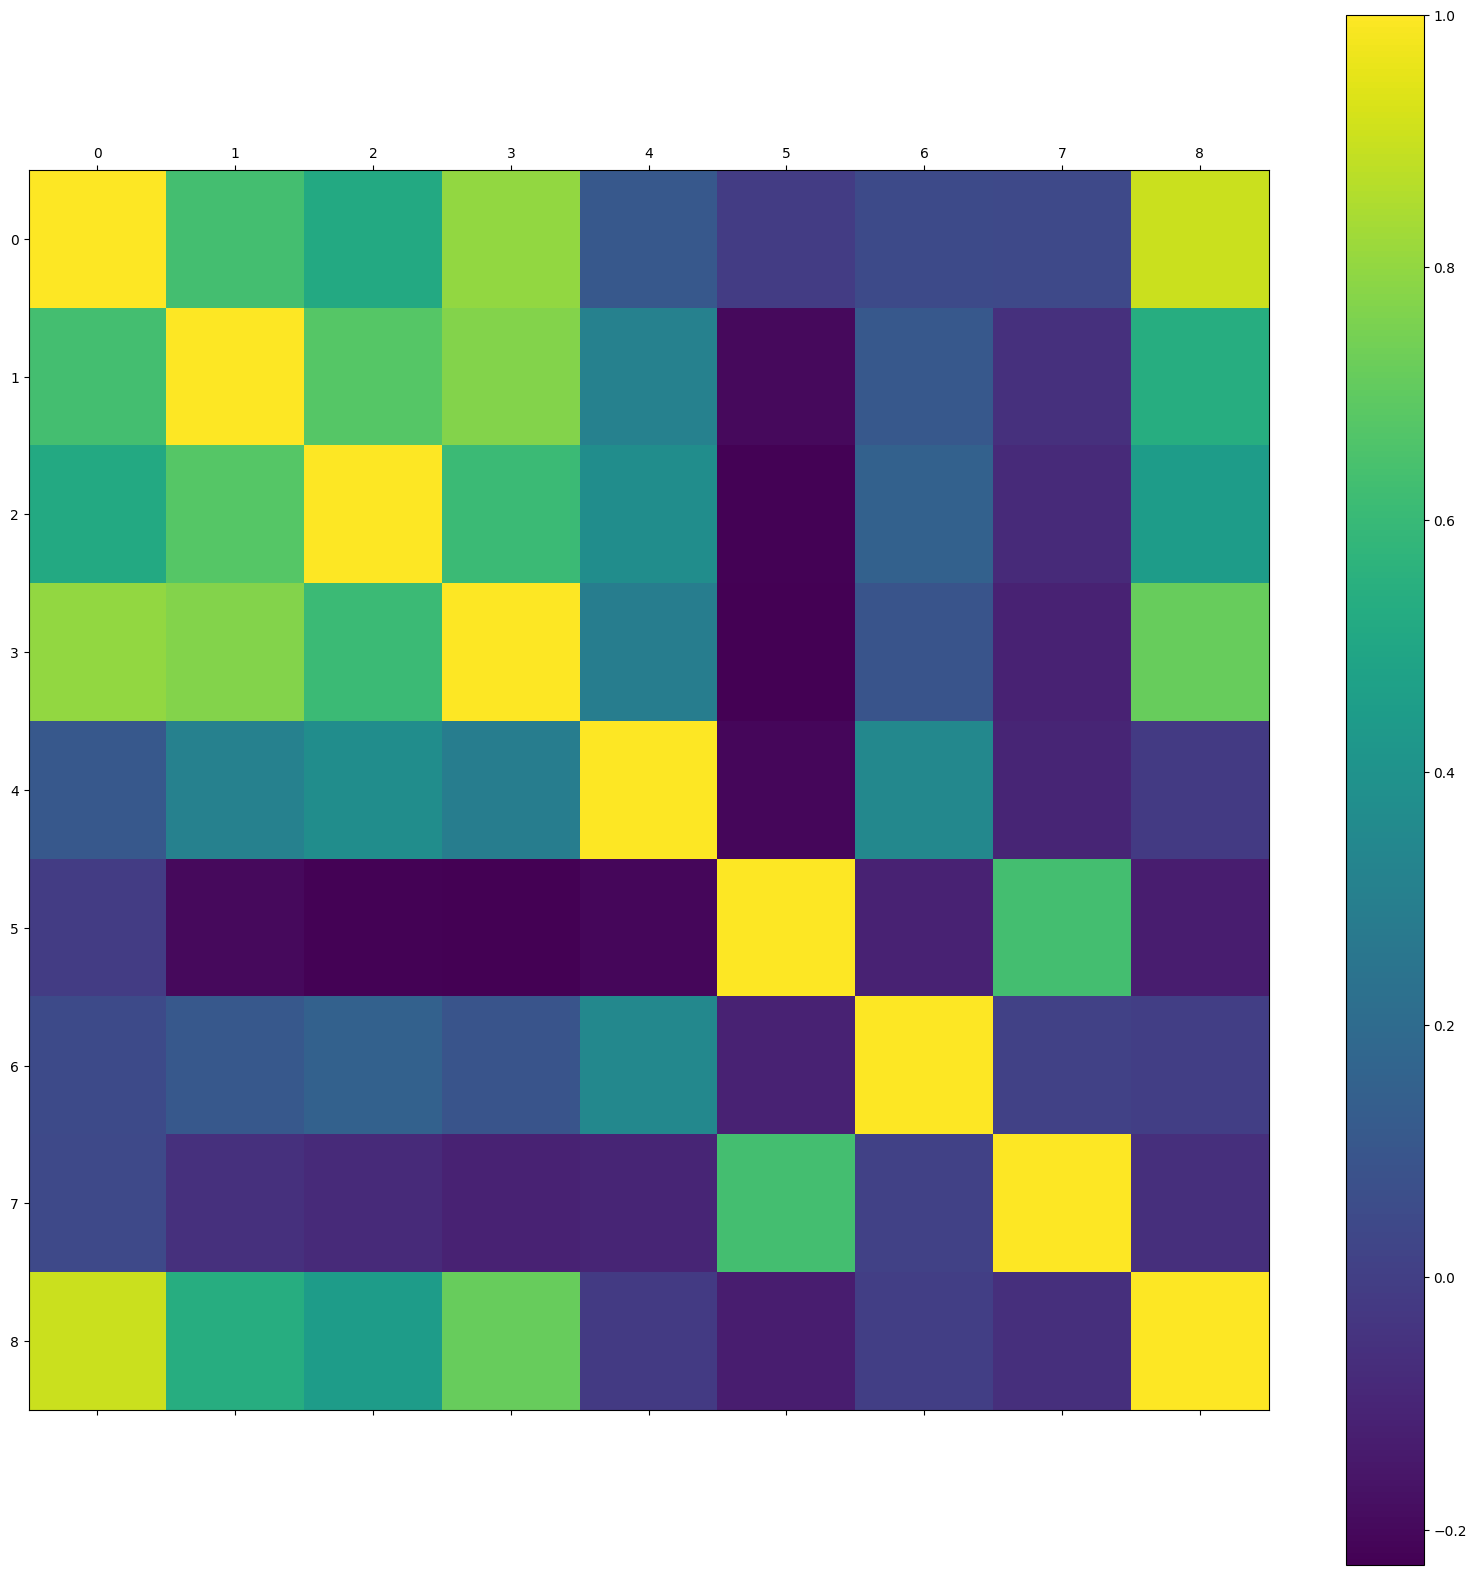

In [967]:
# Correlation between features
correlation_matrix = X_train.corr()
plt.figure(figsize=(20, 20))
plt.matshow(correlation_matrix, fignum=1)
plt.colorbar()


In [968]:
# Let's make a PCA to see if we can reduce the number of features
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
pca.fit(X_train)
X_pca = pca.transform(X_train)
print(f"original shape: {X_train.shape}")
print(f"transformed shape: {X_pca.shape}")

original shape: (10605, 9)
transformed shape: (10605, 7)


<AxesSubplot: >

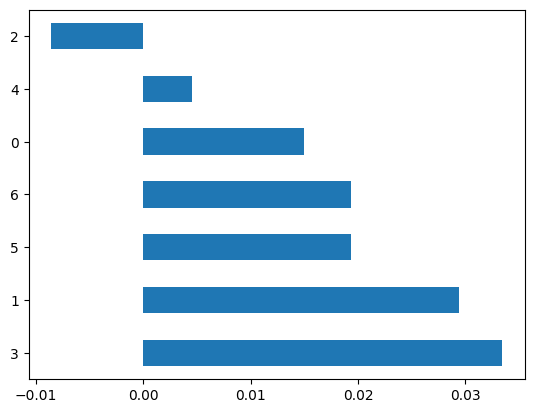

In [969]:
# Let's see the correlation between the new features and predicted_spot_price
correlation = pd.DataFrame(X_pca).corrwith(Y_train['spot_id_delta'])
correlation = correlation.sort_values(ascending=False)
correlation.plot(kind='barh')

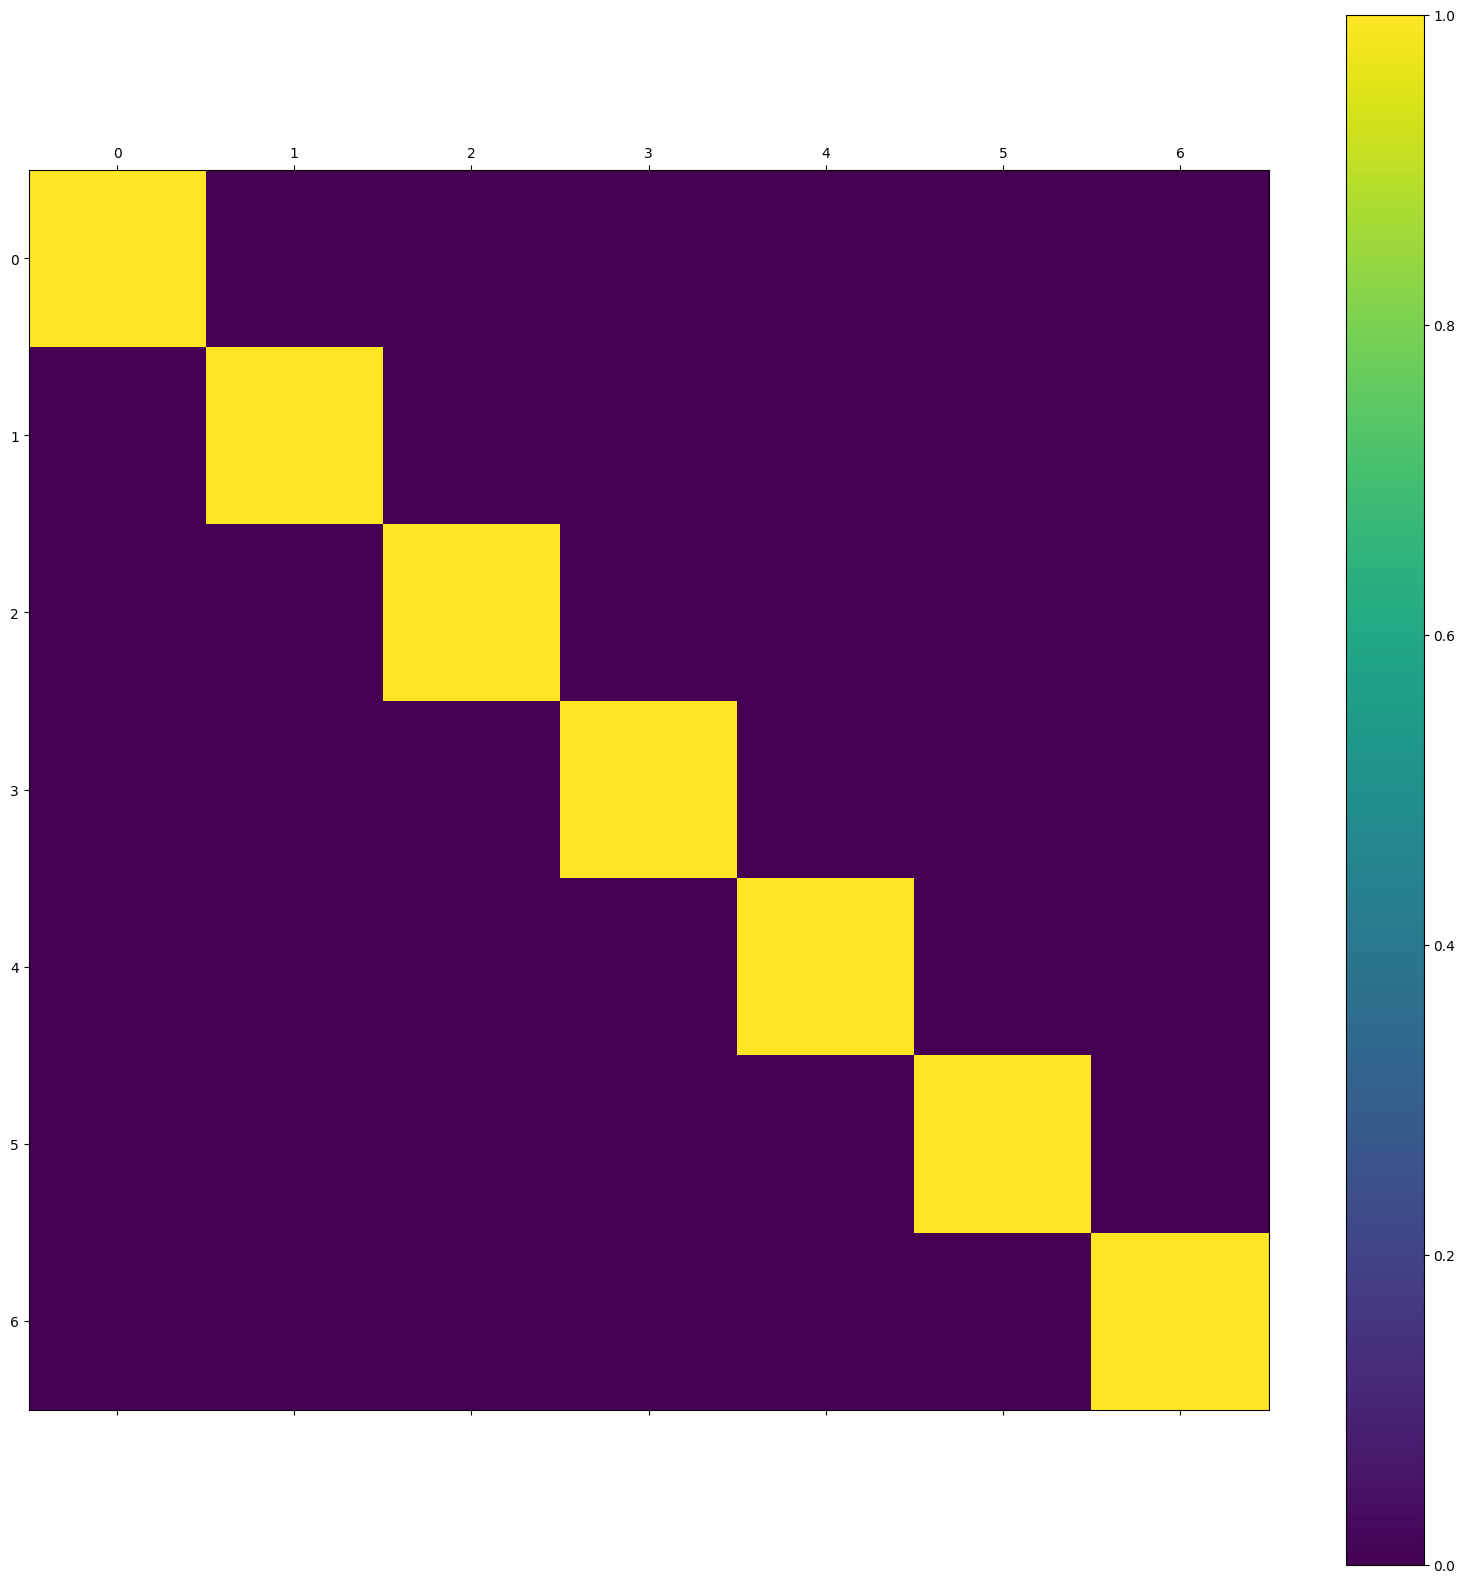

In [970]:
# Correlation between features
correlation_matrix = pd.DataFrame(X_pca).corr()
plt.figure(figsize=(20, 20))
plt.matshow(correlation_matrix, fignum=1)
plt.colorbar()


In [971]:
print(f"percentage of positive values: {np.sum(Y_train['spot_id_delta'].values>0)/len(Y_train['spot_id_delta'].values)}")


percentage of positive values: 0.5016501650165016


In [972]:

from xgboost import XGBRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg


# make pandas dataframe x and y with X_pca and Y_Train
date = pd.to_datetime(Y_train['DELIVERY_START'])
Y_train.drop(columns=['DELIVERY_START'], inplace=True)

X_pca = pd.DataFrame(X_pca)
X_pca.index = range(len(X_pca))
y_train = pd.Series(Y_train['spot_id_delta'])
y_train.index = range(len(y_train))

n = 0.95
x_train_forecast, x_test_forecast, y_train_forecast, y_test_forecast = X_pca.iloc[:int(len(X_pca)*n)], X_pca.iloc[int(len(X_pca)*n):], y_train.iloc[:int(len(y_train)*n)], y_train.iloc[int(len(y_train)*n):]

# Create the model
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(max_depth=10, n_estimators=100, objective='reg:squarederror'),
                 lags      = 21
             )

# Fit the model
forecaster.fit(exog=x_train_forecast, y=y_train_forecast)

# Predict and evaluate the model
# Test set
y_pred_test = forecaster.predict(steps=len(x_test_forecast), exog=x_test_forecast)
weight = np.abs(y_test_forecast)
score = np.sum(weight * (np.sign(y_pred_test*y_test_forecast)>0)) / np.sum(weight)

print(f"Score train : {score}")

Score train : 0.49537422693071853
